# High-NA vectorial PSF generation

In [78]:
from typing import Optional, Tuple

import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from flax.core import freeze, unfreeze
from jax import random

from chromatix.elements import (
    FFLens,
    GaussianSource,
    ZernikeAberrations,
    trainable,
)
from chromatix.ops import shot_noise

key = random.PRNGKey(42)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Incident field

See the gaussian envelope element. 

## Correction factors

Not implemented for now, we use the Zernike aberrations.

## Fourier transform

Not needed for now, we will use FFLens().

## Putting stuff together

In [98]:
class ZernikePSF(nn.Module):
    ansi_indices = np.arange(1, 11)
    camera_shape: Tuple[int, int] = (256, 256)
    camera_pixel_pitch: float = 0.125
    f: float = 100
    NA: float = 1.5
    n: float = 1.33
    wavelength: float = 0.532
    wavelength_ratio: float = 1.0
    upsample: int = 4
    pad: int = 128
    taper_width: Optional[float] = 5

    @nn.compact
    def __call__(self):
        # Some preliminaries
        shape = tuple(np.array(self.camera_shape) * self.upsample + self.pad)
        spacing = (
            self.upsample
            * self.f
            * self.wavelength
            / (self.n * shape[0] * self.camera_pixel_pitch)
        )

        # Actual simulation
        # The only learnable parameters are the Zernike coefficients (since we use the trainable flag)

        field = GaussianSource(
            shape,
            spacing,
            self.wavelength,
            self.wavelength_ratio,
            self.f,
            self.n,
            self.NA,
            power=1e7,
            amplitude=np.array([0.0, 0.0, 1.0]),
            scalar=False,
            envelope_waist=1,
        )(z=0)

        field = ZernikeAberrations(
            trainable(jnp.zeros_like(self.ansi_indices, dtype=jnp.float32)),
            self.f,
            self.n,
            self.NA,
            self.ansi_indices,
        )(field)

        field = FFLens(self.f, self.n, self.NA)(field)
        return field

In [99]:
# model = ZernikePSF()
# variables = model.init(key)
# params, state = variables["params"], variables["state"]
# del variables  # delete for memory
# print(params)
#
# # Specify "ground truth" parameters for Zernike coefficients
# coefficients_truth = jnp.array([0.0, 0.0, 0.0, 0.5, 0, 0, 0, 0, 0, 0])
# params_true = unfreeze(params)
# params_true["ZernikeAberrations_0"]["_coefficients"] = coefficients_truth
# params_true = freeze(params_true)
# print(params_true)
#
#
# field = model.apply({"params": params, "state": state})
# field.shape

(1, 1152, 1152, 1, 1)
(1, 1152, 1152, 1, 3)
(1, 1152, 1152, 1, 3)
(1, 1152, 1152, 1, 1)
(1, 1152, 1152, 1, 3)
(1, 1152, 1152, 1, 3)


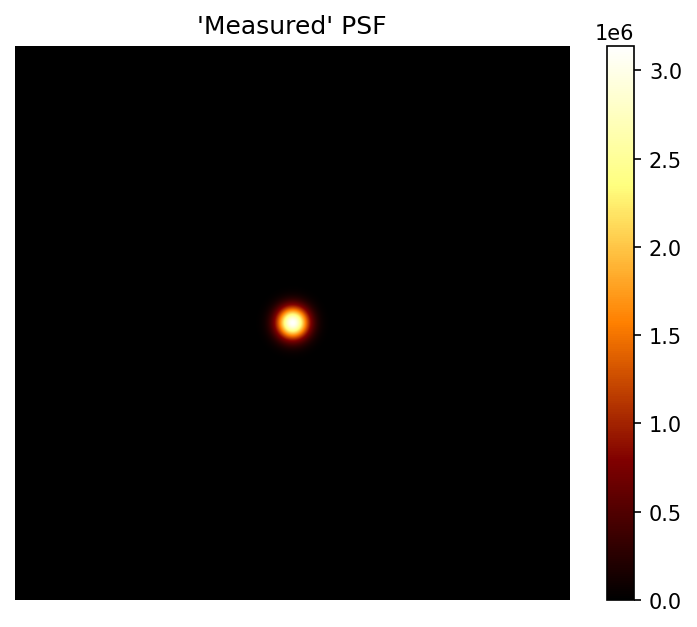

In [100]:
# Initialize model
model = ZernikePSF()
variables = model.init(key)
params, state = variables["params"], variables["state"]
del variables  # delete for memory

# Specify "ground truth" parameters for Zernike coefficients
coefficients_truth = jnp.array([0.0, 0.0, 0.0, 0, 0, 0, 0, 0, 0, 0])
params_true = unfreeze(params)
params_true["ZernikeAberrations_0"]["_coefficients"] = coefficients_truth
params_true = freeze(params_true)

# Generating data
psf_truth = model.apply({"params": params_true, "state": state})
psf_truth = shot_noise(key, psf_truth.intensity)  # add shot noise
# psf_truth = psf_truth.intensity
# psf_truth = psf_truth.phase

crop = 1000
plt.figure(dpi=150)
plt.imshow(psf_truth.squeeze(), cmap="afmhot")
plt.colorbar()
plt.title("'Measured' PSF")
plt.axis("off")
plt.show()